<H3>PRI 2023/24: First Project Delivery</H3>

**GROUP 04**
- Joaquim Bação, 96656
- Jorge Santos, 99258
- Francisco Abreu, 110946

<H3>Part I: demo of facilities</H3>

In [1]:
%pip install whoosh
%pip install ir_datasets
%pip install ir-measures
%pip install pytrec_eval
%pip install gensim
%pip install nltk
%pip install wordcloud

import ir_datasets
import os
import time
import shutil
import numpy as np
import matplotlib.pyplot as plt
import pytrec_eval
import sys
import pandas as pd
import re
import nltk
import gensim
import math

from whoosh import fields, index, qparser
from whoosh.analysis import StandardAnalyzer, SimpleAnalyzer, StemmingAnalyzer, RegexTokenizer, LanguageAnalyzer
from whoosh.qparser import QueryParser, OrGroup, MultifieldParser, AndGroup
from whoosh.scoring import TF_IDF, BM25F, PL2, Frequency
from collections import Counter, defaultdict, namedtuple
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import average_precision_score, ndcg_score

from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from gensim.models import Word2Vec

nltk.download('stopwords')
nltk.download('punkt')


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
# extract datatset
dataset = ir_datasets.load("cord19/trec-covid")
for doc in dataset.docs_iter():
    doc # namedtuple<doc_id, title, doi, date, abstract, body> body: Tuple[title, text]

# qrel  namedtuple<query_id, doc_id, relevance, iteration
# query namedtuple<query_id, title, description, narrative>

qrels = {}
for qrel in dataset.qrels_iter():
    query_id = str(qrel.query_id)
    doc_id = str(qrel.doc_id)
    relevance = qrel.relevance

    if query_id not in qrels:
        qrels[query_id] = {}

    qrels[query_id][doc_id] = relevance

queries = {str(query.query_id): query.title for query in dataset.queries_iter()}

A) **Indexing** (preprocessing and indexing options)

In [3]:
def indexing(D, preprocessing="stemming"):
    """
    Indexes documents by merging 'title', 'abstract', and 'body' into a single field,
    allowing different preprocessing strategies.

    @param D: Dataset object (from `ir_datasets`).
    @param preprocessing: The type of text preprocessing strategy to apply.
                          Options: "raw", "standard", "stemming".
    @return: Whoosh index object.
    """
    start_time = time.time()

    indexmf_dir = f"indexmf_{preprocessing}_dir"

    if os.path.exists(indexmf_dir):
        shutil.rmtree(indexmf_dir)
    os.mkdir(indexmf_dir)

    if preprocessing == "raw":
      schema = fields.Schema(
        id=fields.TEXT(stored=True),
        title=fields.TEXT(stored=True, analyzer=RegexTokenizer()),
        abstract=fields.TEXT(stored=True, analyzer=RegexTokenizer()),
        date=fields.TEXT(stored=True))
    elif preprocessing == "standard":
      schema = fields.Schema(
        id=fields.TEXT(stored=True),
        title=fields.TEXT(stored=True),
        abstract=fields.TEXT(stored=True),
        date=fields.TEXT(stored=True))
    elif preprocessing == "stemming":
      schema = fields.Schema(
        id=fields.TEXT(stored=True),
        title=fields.TEXT(stored=True, analyzer=StemmingAnalyzer()),
        abstract=fields.TEXT(stored=True, analyzer=StemmingAnalyzer()), #stemming porter? YUP
        date=fields.TEXT(stored=True))
    elif preprocessing == "language":
      schema = fields.Schema(
        id=fields.TEXT(stored=True),
        title=fields.TEXT(stored=True, analyzer=LanguageAnalyzer("en")),
        abstract=fields.TEXT(stored=True, analyzer=LanguageAnalyzer("en")), #stemming snowball? YUP
        date=fields.TEXT(stored=True)) 
    else:
        raise ValueError("Invalid preprocessing option. Choose 'raw', 'standard', 'stemming' or 'language'.")


    ixmf = index.create_in(indexmf_dir, schema)
    writer = ixmf.writer()

    i=0
    for doc in D.docs_iter():
        title = str(doc[1]) if doc[1] else ""   # Title
        abstract = str(doc[4]) if doc[4] else ""  # Abstract
        date = str(doc[3]) if doc[3] else "" #Date
        

        writer.add_document(id=str(doc[0]), title=title, abstract=abstract, date=date)

    writer.commit()

    indexing_time = time.time() - start_time

    index_size = sum(
        os.path.getsize(os.path.join(dirpath, f))
        for dirpath, _, filenames in os.walk(indexmf_dir)
        for f in filenames
    ) / (1024 * 1024)

    print("\nIndexing Completed!")
    print(f"Indexing Time: {indexing_time:.2f} seconds")
    print(f"Index Size: {index_size:.2f} MB")

    return ixmf, indexing_time, index_size

In [4]:
#ixmf_raw = indexing(dataset, preprocessing="raw")
ixmf_stemming = indexing(dataset, preprocessing="stemming")
#ixmf_language = indexing(dataset, preprocessing="language")


Indexing Completed!
Indexing Time: 554.13 seconds
Index Size: 403.87 MB


B) **Boolean Query**

In [5]:
def boolean_query(q, I):
    """
    Performs a Boolean query using the Boolean IR model (OR query).

    @param q: Topic text (query)
    @param I: Index object
    @return: Ordered list of document identifiers
    """
    with I.reader() as reader:
        terms = q.lower().split()
        term_counts = Counter(terms)
        top_terms = terms

        query_string = " OR ".join(top_terms)
        qp = QueryParser("abstract", I.schema, group=OrGroup)
        parsed_query = qp.parse(query_string)

        with I.searcher() as searcher:
            results = searcher.search(parsed_query, limit=None)
            doc_ids = [hit["id"] for hit in results]

        print(f"Boolean Query: {query_string}")
        print(f"Retrieved {len(doc_ids)} documents.")
        return doc_ids

C) **Ranking**

In [6]:
import tracemalloc
import time
import math
from whoosh.qparser import MultifieldParser, OrGroup
from whoosh.scoring import BM25F, PL2, TF_IDF

def ranking(I, query, model="bm25", top_k=1000):
    start_time = time.time()
    retrieved_results = {}
    results = {}

    # === Select model ===
    if model.lower() == "tf-idf":
        weighting_model = TF_IDF()
        boosts = None
    elif model.lower() == "bm25":
        weighting_model = BM25F()
        boosts = None
    elif model.lower() == "bm25f":
        weighting_model = BM25F()
        boosts = {"title": 1, "abstract": 3}
    elif model.lower() == "lm":
        weighting_model = PL2()
        boosts = None
    else:
        raise ValueError("Invalid model. Choose 'tf-idf', 'bm25', 'bm25f', or 'lm'.")

    # === Start memory tracking ===
    tracemalloc.start()

    with I.searcher(weighting=weighting_model) as searcher:
        qp = MultifieldParser(["title", "abstract"], I.schema, fieldboosts=boosts, group=OrGroup)
        parsed_query = qp.parse(query[1])
        retrieved_results = searcher.search(parsed_query, limit=top_k)

        for hit in retrieved_results:
            doc_id = hit["id"]
            doc = searcher.stored_fields(searcher.document_number(id=doc_id))
            date_str = doc.get("date", "")
            year = int(str(date_str)[:4]) if date_str and str(date_str)[:4].isdigit() else 1980 # First year with a document in the collection
            decay = 0.1 * math.exp(-0.1 * (2021 - year))
            results[doc_id] = hit.score * decay

    ranking_time = time.time() - start_time

    # === Stop memory tracking ===
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    # Convert bytes to megabytes
    peak_memory_mb = peak / (1024 * 1024)

    return results, ranking_time, peak_memory_mb


D) **Evaluation**

In [8]:
def evaluation(Q, qrels, D, preprocessing="stemming", ir_model="bm25f", metrics={'map_cut.1000', 'ndcg_cut.1000', 'P_10', 'ndcg_cut.10'}):
    """
    Evaluates retrieval performance using pytrec_eval.

    @param qrels: Dictionary {query_id: {doc_id: relevance}}
    @param results: Dictionary {query_id: {doc_id: score}}
    @return: Evaluation metrics
    """

    results = {}

    index_dir = f"indexmf_{preprocessing}_dir"
    
    if not os.path.exists(index_dir):
        ix = indexing(dataset, preprocessing=preprocessing)
    
    ix = index.open_dir(index_dir)


    for query in Q.items():
        retrieved_results, _, _ = ranking(ix, query, model=ir_model, top_k=1000)
        results[query[0]] = retrieved_results

    evaluator = pytrec_eval.RelevanceEvaluator(qrels, metrics)
    scores = evaluator.evaluate(results)

    final_scores = {metric: sum([v[metric] for v in scores.values()]) / len(scores) for metric in scores[list(scores.keys())[0]]}
    return final_scores, results
    
tfidf_scores, tfidf_results = evaluation(queries, qrels, dataset, ir_model="tf-idf")
print("\nTFIDF Evaluation:")
for metric, score in tfidf_scores.items():
    print(f"{metric}: {score:.4f}")

bm25_scores, bm25_results = evaluation(queries, qrels, dataset, ir_model="bm25")
print("\nBM25 Evaluation:")
for metric, score in bm25_scores.items():
    print(f"{metric}: {score:.4f}")
    
bm25f_scores, bm25f_results = evaluation(queries, qrels, dataset, ir_model="bm25f")
print("\nBM25F Evaluation:")
for metric, score in bm25f_scores.items():
    print(f"{metric}: {score:.4f}")

lm_scores, lm_results = evaluation(queries, qrels, dataset, ir_model="lm")
print("\nLM Evaluation:")
for metric, score in lm_scores.items():
    print(f"{metric}: {score:.4f}")


TFIDF Evaluation:
P_10: 0.5020
ndcg_cut_10: 0.4413
ndcg_cut_1000: 0.2615
map_cut_1000: 0.0960

BM25 Evaluation:
P_10: 0.7080
ndcg_cut_10: 0.6631
ndcg_cut_1000: 0.3773
map_cut_1000: 0.1916

BM25F Evaluation:
P_10: 0.7320
ndcg_cut_10: 0.6687
ndcg_cut_1000: 0.3890
map_cut_1000: 0.2021

LM Evaluation:
P_10: 0.7100
ndcg_cut_10: 0.6588
ndcg_cut_1000: 0.3823
map_cut_1000: 0.1958


<H3>Part II: questions materials (optional)</H3>

**(1)** Corpus *D* and summaries *S* description.

        title_length  abstract_length
count  192509.000000    192509.000000
mean       12.608917       139.951535
std         5.934795       133.038119
min         0.000000         0.000000
25%         9.000000         0.000000
50%        12.000000       147.000000
75%        16.000000       229.000000
max       146.000000     18000.000000
     doc_id  title_length  abstract_length        date
0  ug7v899j            15              262  2001-07-04
1  02tnwd4m             8              142  2000-08-15
2  ejv2xln0             6              219  2000-08-25
3  2b73a28n             6               68  2001-02-22
4  9785vg6d            10              110  2001-05-11


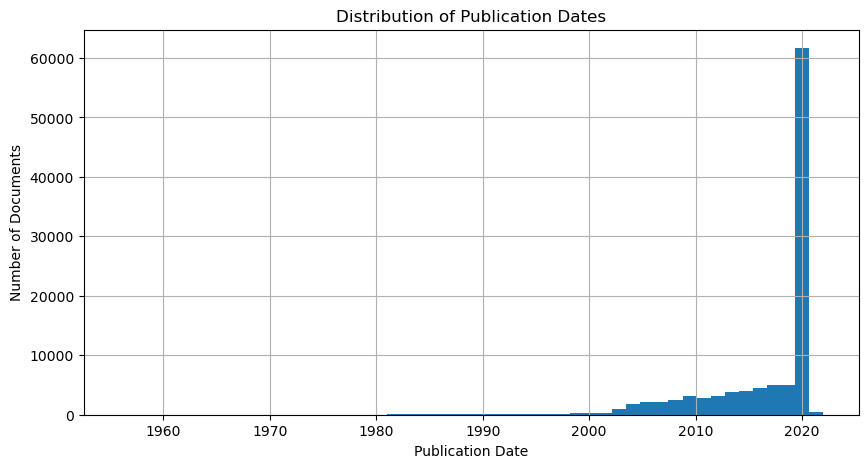

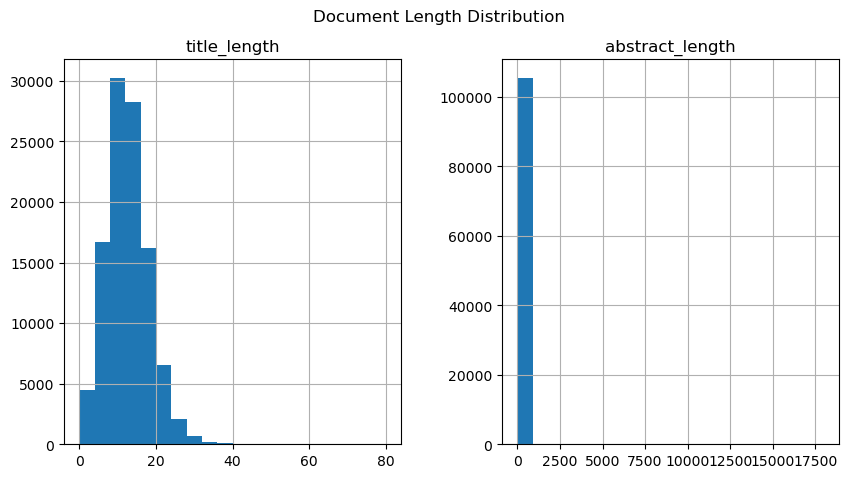

Processing topics...
       query_length
count     50.000000
mean       3.240000
std        1.221575
min        2.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        7.000000


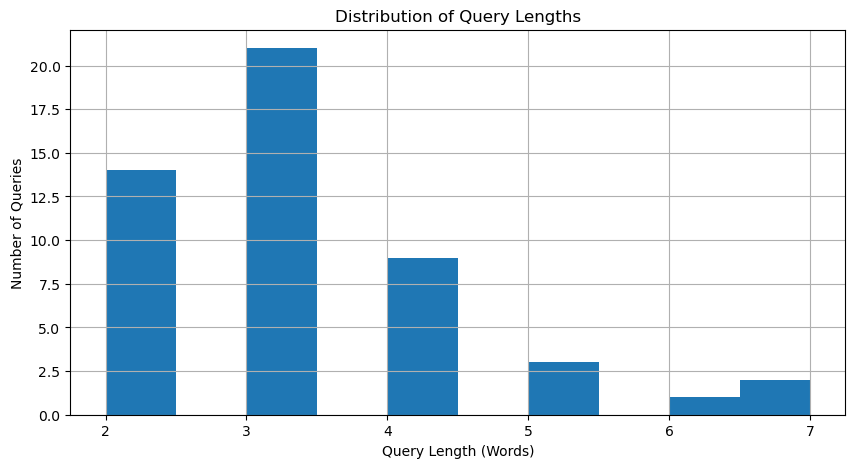

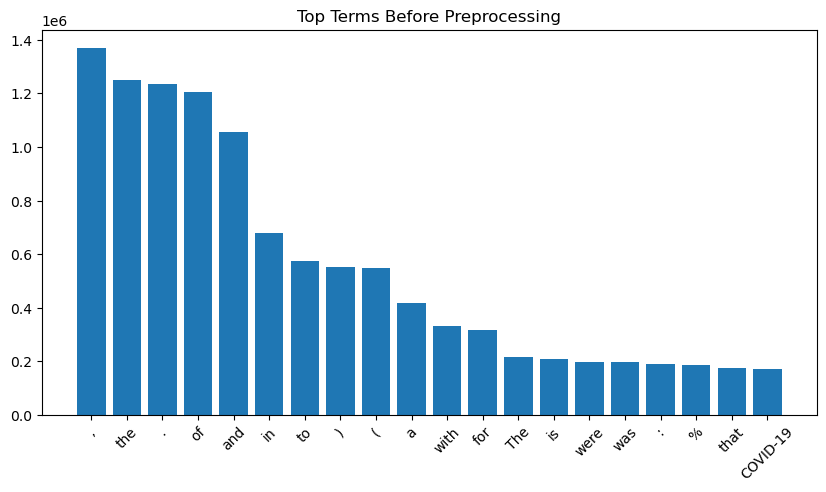

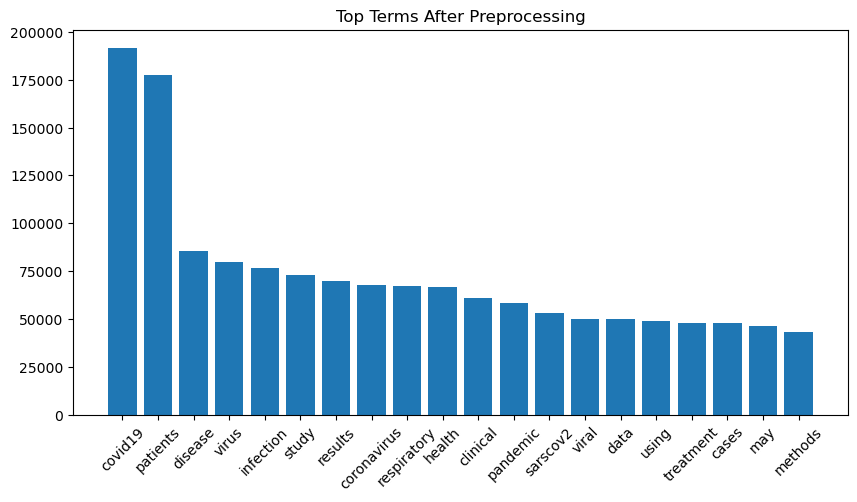

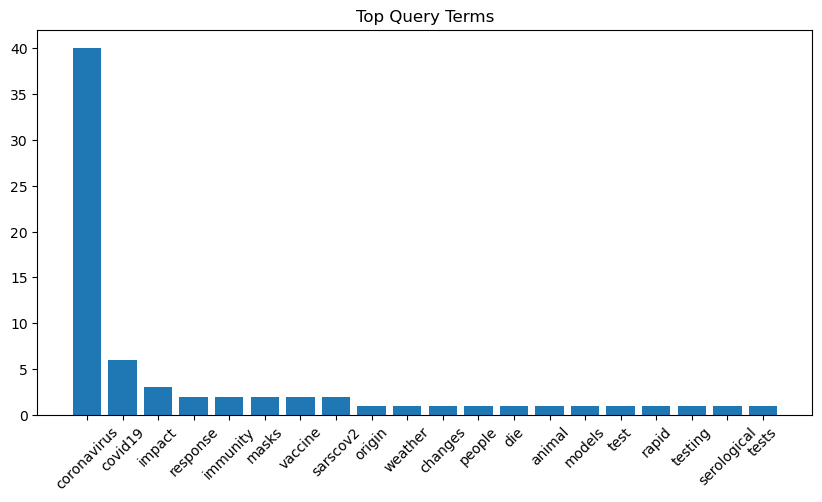

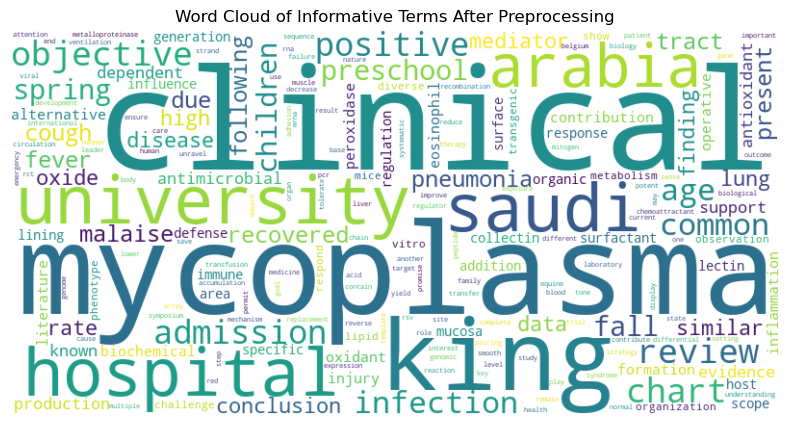

Overlapping Top Terms: ['transmission', 'vaccine', 'response', 'testing', 'early', 'remdesivir', 'symptoms', 'rationing', 'sarscov2', 'storm', 'kills', 'origin', 'rapid', 'biomarkers', 'spreaders', 'outcomes', 'changes', 'distancing', 'clinical', 'immunity']
Semantic Overlapping Terms using Word2Vec: {'transmission': ['transmissions', 'spread', 'spillover', 'spreading', 'contagion'], 'vaccine': ['vaccines', 'vaccination', 'vaccinations', 'immunization', 'immunogenicity'], 'response': ['responses', 'responsemediated', 'suppression', 'defenses', 'thrombocytopaenic'], 'testing': ['tests', 'test', 'screening', 'confirmation', 'serology'], 'early': ['earlier', 'initial', 'earliest', 'late', 'later'], 'remdesivir': ['favipiravir', 'lopinavirritonavir', 'lopinavir', 'chloroquine', 'ribavirin'], 'symptoms': ['symptom', 'complaints', 'illness', 'symptomatology', 'manifestations'], 'rationing': ['allocation', 'allocating', 'allocations', 'equitable', 'utilisation'], 'sarscov2': ['2019ncov', 'cov

In [9]:
dataset = ir_datasets.load("cord19/trec-covid")

stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text.lower())  # Remove special characters
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    return tokens

doc_texts = []
doc_metadata = []
for doc in dataset.docs_iter():
    text = doc.title + " " + (doc.abstract if doc.abstract else "")
    doc_texts.append(text)
    doc_metadata.append({
        "doc_id": doc.doc_id,
        "title_length": len(doc.title.split()),
        "abstract_length": len(doc.abstract.split()) if doc.abstract else 0,
        "date": doc.date
    })

doc_metadata_df = pd.DataFrame(doc_metadata)
print(doc_metadata_df.describe())
print(doc_metadata_df.head())

doc_metadata_df['date'] = pd.to_datetime(doc_metadata_df['date'], errors='coerce')
doc_metadata_df.dropna(subset=['date'], inplace=True)
plt.figure(figsize=(10, 5))
doc_metadata_df['date'].hist(bins=50)
plt.xlabel("Publication Date")
plt.ylabel("Number of Documents")
plt.title("Distribution of Publication Dates")
plt.show()

doc_metadata_df[['title_length', 'abstract_length']].hist(bins=20, figsize=(10, 5))
plt.suptitle("Document Length Distribution")
plt.show()

preprocessed_docs = [preprocess_text(text) for text in doc_texts]

all_terms_before = Counter(word_tokenize(' '.join(doc_texts)))
all_terms_after = Counter(word for doc in preprocessed_docs for word in doc)

word2vec_model = Word2Vec(sentences=preprocessed_docs, vector_size=100, window=5, min_count=2, workers=4)

print("Processing topics...")
query_texts = []
query_metadata = []
for query in dataset.queries_iter():
    query_texts.append(query.title)
    query_metadata.append({
        "query_id": query.query_id,
        "query_length": len(query.title.split())
    })

query_metadata_df = pd.DataFrame(query_metadata)
print(query_metadata_df.describe())

plt.figure(figsize=(10, 5))
query_metadata_df['query_length'].hist(bins=10)
plt.xlabel("Query Length (Words)")
plt.ylabel("Number of Queries")
plt.title("Distribution of Query Lengths")
plt.show()

preprocessed_queries = [preprocess_text(text) for text in query_texts]

query_terms = Counter(word for query in preprocessed_queries for word in query)

def get_similar_words(word2vec_model, query_terms, top_n=10):
    similar_terms = {}
    for term in query_terms:
        if term in word2vec_model.wv:
            similar_terms[term] = [w for w, _ in word2vec_model.wv.most_similar(term, topn=top_n)]
    return similar_terms

overlapping_terms = set(all_terms_after.keys()).intersection(set(query_terms.keys()))
semantic_overlapping_terms = get_similar_words(word2vec_model, overlapping_terms, top_n=5)

def plot_term_distribution(counter, title):
    top_terms = counter.most_common(20)
    words, counts = zip(*top_terms)
    plt.figure(figsize=(10, 5))
    plt.bar(words, counts)
    plt.xticks(rotation=45)
    plt.title(title)
    plt.show()

plot_term_distribution(all_terms_before, "Top Terms Before Preprocessing")
plot_term_distribution(all_terms_after, "Top Terms After Preprocessing")
plot_term_distribution(query_terms, "Top Query Terms")

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_terms_after.keys()))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Informative Terms After Preprocessing")
plt.show()

print("Overlapping Top Terms:", list(overlapping_terms)[:20])
print("Semantic Overlapping Terms using Word2Vec:", semantic_overlapping_terms)

**(2)** Summarization performance for the overall and category-conditional corpora.

In [10]:
def evaluate_all_queries(index, queries, model="bm25", top_k=1000):
    total_time = 0.0
    total_memory = 0.0
    num_queries = 0

    for query in queries.items():
        _, ranking_time, memory_used = ranking(index, query, model=model, top_k=top_k)
        total_time += ranking_time
        total_memory += memory_used
        num_queries += 1

    avg_time = total_time / num_queries
    avg_memory = total_memory / num_queries
    return None, avg_time, avg_memory
    
# PLOT RANKING GRAPH
def plot_ranking_graph(*ranking_results_with_labels):
    
    # Extract labels and ranking results (ranking_time and memory_used)
    labels = [label for label, rdata in ranking_results_with_labels]
    ranking_times = []
    memory_usages = []

    # Extract ranking times and memory usage from results tuples
    for _, rdata in ranking_results_with_labels:
        _, ranking_time, memory_used = rdata  # Extract time and memory
        ranking_times.append(ranking_time)
        memory_usages.append(memory_used)

    # Calculate positions and bar width
    x = np.arange(len(labels))  # Label positions
    width = 0.35  # Width of bars
    spacing = 0.05  # Space between bars

    # Adjust figure size
    fig, ax1 = plt.subplots(figsize=(9, 4.5))

    # Left axis (memory usage)
    ax1.set_xlabel("Ranking Method", labelpad=15)
    ax1.set_ylabel("Memory Usage (MB)", color="#2074b4")  # Google blue for memory usage
    ax1.bar(x - width/2 - spacing, memory_usages, width, color="#2074b4", label="Memory Usage")

    # Add values above the "memory usage" bars
    for i, size in enumerate(memory_usages):
        ax1.text(x[i] - width/2 - spacing, size + 0.03, f"{size:.2f}", ha="center", color="#2074b4")

    ax1.tick_params(axis='y', labelcolor="#2074b4")

    # Right axis (ranking time)
    ax2 = ax1.twinx()
    ax2.set_ylabel("Ranking Time (s)", color="seagreen")  # Green for ranking time
    ax2.bar(x + width/2 + spacing, ranking_times, width, color="mediumseagreen", label="Ranking Time")

    # Add values above the "ranking time" bars
    for i, time in enumerate(ranking_times):
        ax2.text(x[i] + width/2 + spacing, time + 0.03, f"{time:.2f}", ha="center", color="seagreen")

    ax2.tick_params(axis='y', labelcolor="seagreen")

    # Labels and layout
    ax1.set_xticks(x)
    ax1.set_xticklabels(labels, rotation=0, ha="center")

        # Adjust y-axis limits
    ax1.set_ylim(0, 450)
    ax2.set_ylim(0, 70)

    fig.tight_layout()

    plt.title("Ranking Performance Comparison")

    # Save the plot to a file
    plt.savefig("ranking_performance_comparison.png")
    plt.close()


# Example usage:
plot_ranking_graph(
    ("TF-IDF", evaluate_all_queries(index, queries, model="tf-idf")),
    ("BM25", evaluate_all_queries(index, queries, model="bm25")),
    ("BM25F", evaluate_all_queries(index, queries, model="bm25f")),
    ("LM", evaluate_all_queries(index, queries, model="lm"))
)


# PLOT INDEXING GRAPH
def plot_indexing_graph(*indexing_results_with_labels):
    # Extracting the labels and indexing results (indexing_time and index_size)
    labels = [label for label, ixmf in indexing_results_with_labels]
    indexing_times = []
    index_sizes = []

    # Extract the indexing times and sizes from the ixmf objects
    for _, ixmf in indexing_results_with_labels:
        _, indexing_time, index_size = ixmf
        indexing_times.append(indexing_time)
        index_sizes.append(index_size)

    # Calculate positions and bar width
    x = np.arange(len(labels))  # Label positions
    width = 0.35  # Width of bars (reduced slightly for space between bars)
    spacing = 0.05  # Space between pairs of bars

    # Adjust figure size to make the y-axis taller
    fig, ax1 = plt.subplots(figsize=(9, 4.5))  # Adjusted figure height

    # Left axis (index size)
    ax1.set_xlabel("Indexing Method", labelpad=15)
    ax1.set_ylabel("Index Size (MB)", color="#2074b4")  # Google blue for index size
    ax1.bar(x - width/2 - spacing, index_sizes, width, color="#2074b4", label="Index Size")

    # Add values just above the "index size" bars
    for i, size in enumerate(index_sizes):
        ax1.text(x[i] - width/2 - spacing, size + 0.03, f"{size:.2f}", ha="center", color="#2074b4")

    ax1.tick_params(axis='y', labelcolor="#2074b4")

    # Right axis (indexing time)
    ax2 = ax1.twinx()
    ax2.set_ylabel("Indexing Time (s)", color="seagreen")  # Green for indexing time
    ax2.bar(x + width/2 + spacing, indexing_times, width, color="mediumseagreen", label="Indexing Time")

    # Add values just above the "indexing time" bars
    for i, time in enumerate(indexing_times):
        ax2.text(x[i] + width/2 + spacing, time + 0.03, f"{time:.2f}", ha="center", color="seagreen")

    ax2.tick_params(axis='y', labelcolor="seagreen")

    # Labels and layout
    ax1.set_xticks(x)
    ax1.set_xticklabels(labels, rotation=0, ha="center")

    # Adjust y-axis limits
    ax1.set_ylim(0, 600)
    ax2.set_ylim(0, 600)

    fig.tight_layout()

    plt.title("Indexing Performance Comparison")

    # Save the plot to a file
    plt.savefig("indexing_performance_comparison.png")
    plt.close()

# Example Usage
plot_indexing_graph(("Raw Preprocessing", ixmf_raw), ("Standard Preprocessing",ixmf_standard), ("Stemming Preprocessing",ixmf_stemming), ("Language Preprocessing", ixmf_language))

AttributeError: module 'whoosh.index' has no attribute 'searcher'

**(3)** Graphic - IR Model Results side by side

{'P_10': 0.502, 'ndcg_cut_10': 0.4413007424611016, 'ndcg_cut_1000': 0.2615292958926833, 'map_cut_1000': 0.09601124747970534}
{'P_10': 0.708, 'ndcg_cut_10': 0.6630925226174799, 'ndcg_cut_1000': 0.37732623768192625, 'map_cut_1000': 0.19159877982783002}
{'P_10': 0.732, 'ndcg_cut_10': 0.6687471309495795, 'ndcg_cut_1000': 0.3889559530302924, 'map_cut_1000': 0.20207096455605686}
{'P_10': 0.71, 'ndcg_cut_10': 0.6588478436792055, 'ndcg_cut_1000': 0.382261603050831, 'map_cut_1000': 0.19579954403764518}


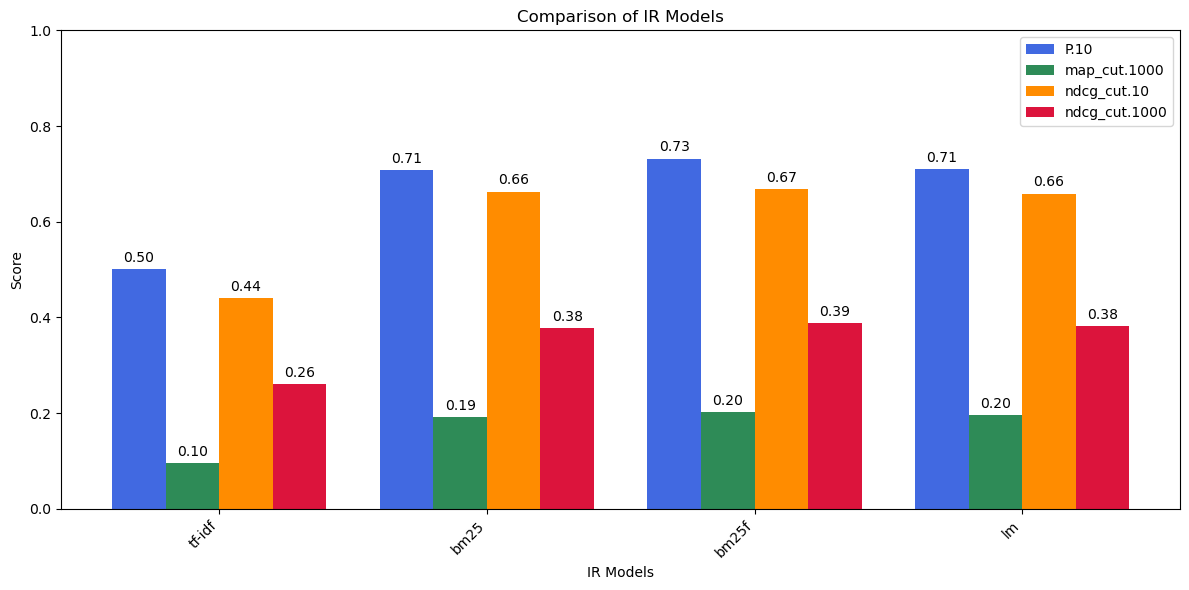

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Define models techniques
ir_models = ["tf-idf", "bm25", "bm25f", "lm"]

# Metrics to capture
metrics = ['P.10', 'map_cut.1000', 'ndcg_cut.10', 'ndcg_cut.1000']
values =['P_10', 'map_cut_1000', 'ndcg_cut_10', 'ndcg_cut_1000']

# Dictionary to store results
results_dict = {metric: [] for metric in values}
labels = []  # Labels for X-axis

for ir_model in ir_models:
    scores, _ = evaluation(queries, qrels, dataset, ir_model=ir_model)
    print(scores)

    # Store scores for each metric
    for i in range(len(values)):
        results_dict[values[i]].append(scores.get(values[i], 0))

    # Create label for this execution
    labels.append(f"{ir_model}")

# Create grouped bar chart
x = np.arange(len(labels))  # X locations for bars
width = 0.2  # Width of bars

fig, ax = plt.subplots(figsize=(12, 6))

# Create bars for each metric
bars = []
colors = ['royalblue', 'seagreen', 'darkorange', 'crimson']

for i, (metric, value_key) in enumerate(zip(metrics, values)):
    bars.append(ax.bar(x + i * width - width * 1.5, results_dict[value_key], width, label=metric, color=colors[i]))

# Formatting
ax.set_xlabel("IR Models")
ax.set_ylabel("Score")
ax.set_title("Comparison of IR Models")
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha="right")
ax.legend()

# Add value labels
for bar_group in bars:
    for bar in bar_group:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.ylim(0, 1)
plt.tight_layout()
plt.savefig("ir_model_comparison.png", dpi=300, bbox_inches='tight')  # Save the plot
plt.show()

In [13]:
#(4) Graphic -  Precision & Recall with the increase of p

In [14]:
def evaluation_at_cutoffs(Q, qrels, D, preprocessing="stemming", ir_model="bm25f", cutoffs=range(5, 1001, 5)):
    results = {}

    # Collect search results
    for query in Q.items():
        retrieved_results = ranking(index, query, model=ir_model, top_k=1000)[0]
        results[query[0]] = retrieved_results

    # Build metric names
    metrics = {f"P_{k}" for k in cutoffs}
    metrics.update({f"recall_{k}" for k in cutoffs})

    evaluator = pytrec_eval.RelevanceEvaluator(qrels, metrics)
    scores = evaluator.evaluate(results)

    # Average metrics across all queries
    averaged_scores = {metric: 0.0 for metric in metrics}
    for score in scores.values():
        for metric in score:
            averaged_scores[metric] += score[metric]
    for metric in averaged_scores:
        averaged_scores[metric] /= len(scores)

    return averaged_scores

import matplotlib.pyplot as plt

def plot_precision_recall_curve(score_dict, model_name="BM25", cutoffs=range(5, 1001, 5)):
    precisions = [score_dict[f"P_{k}"] for k in cutoffs]
    recalls = [score_dict[f"recall_{k}"] for k in cutoffs]

    plt.figure(figsize=(10, 5))
    plt.plot(cutoffs, precisions, label="Precision", color="royalblue")
    plt.plot(cutoffs, recalls, label="Recall", color="seagreen")
    plt.xlabel("Cutoff (p)")
    plt.ylabel("Score")
    plt.title(f"Precision and Recall vs Cutoff — {model_name}")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"{model_name}_precision_recall.png")
    plt.show()

cutoff_range = range(5, 1001, 5)

bm25f_metrics = evaluation_at_cutoffs(queries, qrels, dataset, preprocessing="stemming", ir_model="bm25f", cutoffs=cutoff_range)
plot_precision_recall_curve(bm25f_metrics, model_name="BM25F", cutoffs=cutoff_range)


AttributeError: module 'whoosh.index' has no attribute 'searcher'

(5)

In [15]:
import pytrec_eval
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def evaluation_per_query(qrels, results):
    """
    Evaluates retrieval performance using pytrec_eval and analyzes per-query variations.

    @param qrels: Dictionary {query_id: {doc_id: relevance}}
    @param results: Tuple containing (results, time, size)
    @return: Per-query evaluation metrics and summary statistics
    """
    evaluator = pytrec_eval.RelevanceEvaluator(qrels, {'map_cut.1000', 'ndcg_cut.1000', 'P.10', 'ndcg_cut.10'})
    scores = evaluator.evaluate(results)

    metrics = list(scores[next(iter(scores))].keys())
    summary_stats = {}

    for metric in metrics:
        values = [scores[q][metric] for q in scores]
        summary_stats[metric] = {
            'mean': np.mean(values),
            'std_dev': np.std(values),
            'min': np.min(values),
            'max': np.max(values),
            'low_performance_queries': [q for q in scores if scores[q][metric] < np.mean(values) - np.std(values)]
        }

    return scores, summary_stats


# Evaluate all models
models = {
    "TF-IDF": tfidf_results,
    "BM25": bm25_results,
    "BM25F": bm25f_results,
    "LM": lm_results
}

evaluations = {name: evaluation_per_query(qrels, res) for name, res in models.items()}

# Print summary
print("\n=== Summary Statistics ===")
metrics = list(next(iter(evaluations.values()))[1].keys())
for metric in metrics:
    print(f"\nMetric: {metric}")
    for model_name, (per_query, stats) in evaluations.items():
        print(f"{model_name} - Mean: {stats[metric]['mean']:.4f}, Std Dev: {stats[metric]['std_dev']:.4f}, "
              f"Min: {stats[metric]['min']:.4f}, Max: {stats[metric]['max']:.4f}")
        print(f"Low Performance Queries ({model_name}): {stats[metric]['low_performance_queries']}")

# Print per-query scores
print("\n=== Per-Query Scores ===")
for model_name, (per_query, _) in evaluations.items():
    print(f"\n{model_name} Per-Query Evaluation:")
    for query_id, metric_vals in per_query.items():
        print(f"Query {query_id}: " + ", ".join([f"{metric}: {val:.4f}" for metric, val in metric_vals.items()]))

for i, metric in enumerate(metrics):
    metric_data = [ [v[metric] for v in evaluations[model][0].values()] for model in models ]
    means = [np.mean(data) for data in metric_data]  # Compute mean per model

    # Boxplot
    bp = axs[i].boxplot(metric_data, labels=models.keys(), patch_artist=True,
                        boxprops=dict(facecolor=colors[i], color='black'),
                        medianprops=dict(color='black'))

    # Overlay mean values as red dots
    for j, mean in enumerate(means):
        axs[i].plot(j + 1, mean, marker='o', color='red', label='Mean' if j == 0 else "")

    axs[i].set_title(metric)
    axs[i].set_ylabel("Score")
    axs[i].set_ylim(0, 1)
    axs[i].grid(True, axis='y', linestyle='--', alpha=0.5)

# Add legend just once
handles, labels_ = axs[0].get_legend_handles_labels()
if handles:
    fig.legend(handles, labels_, loc='upper right')

fig.suptitle("Per-Query Score Distribution (Boxplots) with Mean Overlay", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("metrics_per_model_boxplot_with_means.png", dpi=300, bbox_inches='tight')
plt.show()

# === Heatmap of Mean Scores ===
summary_data = []
for model_name, (_, stats) in evaluations.items():
    for metric in metrics:
        summary_data.append({
            "Model": model_name,
            "Metric": metric,
            "Mean": stats[metric]["mean"],
            "Min": stats[metric]["min"],
            "Max": stats[metric]["max"],
            "StdDev": stats[metric]["std_dev"]
        })

df = pd.DataFrame(summary_data)

plt.figure(figsize=(12, 6))
sns.heatmap(df.pivot(index="Model", columns="Metric", values="Mean"), annot=True, cmap="Blues", fmt=".3f")
plt.title("Heatmap of Mean Scores by Metric & Model")
plt.tight_layout()
plt.show()



=== Summary Statistics ===

Metric: P_10
TF-IDF - Mean: 0.5020, Std Dev: 0.3228, Min: 0.0000, Max: 1.0000
Low Performance Queries (TF-IDF): ['4', '5', '8', '11', '31', '34', '35', '49']
BM25 - Mean: 0.7080, Std Dev: 0.3104, Min: 0.0000, Max: 1.0000
Low Performance Queries (BM25): ['3', '4', '11', '12', '13', '15', '31', '32', '34', '49']
BM25F - Mean: 0.7320, Std Dev: 0.2908, Min: 0.0000, Max: 1.0000
Low Performance Queries (BM25F): ['4', '8', '11', '12', '13', '15', '16', '31', '32', '34', '49']
LM - Mean: 0.7100, Std Dev: 0.3048, Min: 0.0000, Max: 1.0000
Low Performance Queries (LM): ['4', '8', '10', '11', '13', '15', '22', '31', '32', '34', '49']

Metric: ndcg_cut_10
TF-IDF - Mean: 0.4413, Std Dev: 0.2974, Min: 0.0000, Max: 0.8611
Low Performance Queries (TF-IDF): ['1', '4', '5', '8', '11', '13', '15', '22', '31', '34', '35', '47', '49']
BM25 - Mean: 0.6631, Std Dev: 0.3016, Min: 0.0000, Max: 1.0000
Low Performance Queries (BM25): ['3', '4', '11', '12', '13', '15', '31', '32', '34'

NameError: name 'axs' is not defined

(6) **Reciprocal Rank Fusion**

In [ ]:
ranking_results = []
ranking_results.append(bm25f_results)
#ranking_results.append(tfidf_results)
ranking_results.append(lm_results)

from collections import defaultdict

def reciprocal_rank_fusion(rankings, k=60):
    """
    Computes Reciprocal Rank Fusion (RRF) over multiple rankings.

    @param rankings: List of ranking dicts per method.
                     Each dict is: {query_id: {doc_id: score}}
    @param k: RRF constant (default=60)
    @return: Dict of {query_id: {doc_id: rrf_score}}, sorted by score descending
    """
    rrf_scores = defaultdict(lambda: defaultdict(float))

    for ranking in rankings:
        for query_id, results in ranking.items():
            ranked_docs = sorted(results.items(), key=lambda x: x[1], reverse=True)
            for position, (doc_id, _) in enumerate(ranked_docs):
                rrf_scores[query_id][doc_id] += 1 / (k + position)

    # Sort each query's docs by RRF score and return as dict
    fused_results = {
        query_id: dict(sorted(doc_scores.items(), key=lambda x: x[1], reverse=True))
        for query_id, doc_scores in rrf_scores.items()
    }

    return fused_results


import matplotlib.pyplot as plt
import numpy as np

def visualize_rrf_results(rrf_results, bm25f_scores, lm_scores, query_text):
    """
    Visualizes the rank positions of BM25, LM, and RRF for the top RRF-ranked documents.
    
    @param rrf_results: list of (doc_id, rrf_score) sorted in descending order
    @param bm25_scores: dict of {doc_id: score} from BM25
    @param lm_scores: dict of {doc_id: score} from LM
    @param query_text: string for title
    """
    # Get top 10 documents by RRF
    top_rrf = rrf_results[:10]
    doc_ids = [doc_id for doc_id, _ in top_rrf]

    # Compute rank positions for each system
    def compute_ranks(score_dict):
        sorted_docs = sorted(score_dict.items(), key=lambda x: x[1], reverse=True)
        return {doc_id: rank + 1 for rank, (doc_id, _) in enumerate(sorted_docs)}

    bm25f_ranks = compute_ranks(bm25f_scores)
    lm_ranks = compute_ranks(lm_scores)
    rrf_ranks = {doc_id: i + 1 for i, (doc_id, _) in enumerate(rrf_results)}

    # Extract ranks for top RRF docs
    bm25f_rank_vals = [bm25f_ranks.get(doc_id, len(bm25f_scores) + 1) for doc_id in doc_ids]
    lm_rank_vals = [lm_ranks.get(doc_id, len(lm_scores) + 1) for doc_id in doc_ids]
    rrf_rank_vals = [rrf_ranks.get(doc_id, len(rrf_results) + 1) for doc_id in doc_ids]

    # Print values
    print("\n=== Ranking Comparison for Query ===")
    print(f"Query: {query_text}")
    for i, doc_id in enumerate(doc_ids):
        print(f"Document: {doc_id}")
        print(f"  RRF Rank: {rrf_rank_vals[i]}")
        print(f"  BM25F Rank: {bm25f_rank_vals[i]}")
        print(f"  LM Rank: {lm_rank_vals[i]}")
        print("-" * 50)

    # Plot
    plt.figure(figsize=(12, 6))
    width = 0.25
    x_range = np.arange(len(doc_ids))

    plt.bar(x_range - width, bm25f_rank_vals, width=width, label="BM25 Rank", color="blue")
    plt.bar(x_range, lm_rank_vals, width=width, label="LM Rank", color="orange")
    plt.bar(x_range + width, rrf_rank_vals, width=width, label="RRF Rank", color="green")

    plt.xlabel("Document ID")
    plt.ylabel("Rank Position (Lower is Better)")
    plt.xticks(ticks=x_range, labels=doc_ids, rotation=45)
    plt.gca().invert_yaxis()  # Lower rank = better, so invert Y
    plt.legend()
    plt.title(f"RRF vs. BM25F vs. LM for Query: {query_text}")
    plt.tight_layout()
    plt.savefig("RRF vs BM25F vs LM", dpi=300, bbox_inches='tight')
    plt.show()


# Example Usage
query = next(dataset.queries_iter())
query_id = query.query_id
query_text = query.title

bm25f_scores = bm25f_results[query_id]      # e.g., {'doc1': 3.5, 'doc2': 2.8, ...}
lm_scores = lm_results[query_id]          # e.g., {'doc1': 0.9, 'doc3': 0.6, ...}

rrf_output = reciprocal_rank_fusion([bm25f_results, lm_results])
rrf_results = sorted(rrf_output[query_id].items(), key=lambda x: x[1], reverse=True)

visualize_rrf_results(rrf_results, bm25f_scores, lm_scores, query_text)








In [16]:
# Comparing RRF/BM25F/LM metric results


# Define models techniques (including RRF)
ir_models = ["bm25f", "lm"]
rrf_label = "rrf"  # Label for RRF in chart

# Metrics to capture
metrics = ['P.10', 'map_cut.1000', 'ndcg_cut.10', 'ndcg_cut.1000']
values = ['P_10', 'map_cut_1000', 'ndcg_cut_10', 'ndcg_cut_1000']

# Dictionary to store results
results_dict = {metric: [] for metric in values}
labels = []

# Store per-model results for RRF fusion
all_model_results = []

# Evaluate base models
for ir_model in ir_models:
    scores, run = evaluation(queries, qrels, dataset, ir_model=ir_model)
    all_model_results.append(run)  # Save run dict for RRF fusion

    # Store metric scores
    for key in values:
        results_dict[key].append(scores.get(key, 0))

    labels.append(ir_model)

# --- Evaluate RRF ---
# RRF expects list of runs like: [{qid: {docid: score, ...}}, ...]
rrf_run = reciprocal_rank_fusion(all_model_results)  # Dict of {qid: {docid: score}}

# Evaluate RRF
evaluator = pytrec_eval.RelevanceEvaluator(qrels, {'map_cut.1000', 'ndcg_cut.1000', 'P_10', 'ndcg_cut.10'})
scores = evaluator.evaluate(rrf_run)

rrf_scores = {metric: sum([v[metric] for v in scores.values()]) / len(scores) for metric in scores[list(scores.keys())[0]]}

# Store RRF scores
for key in values:
    results_dict[key].append(rrf_scores.get(key, 0))

labels.append(rrf_label)

# --- Plotting ---
x = np.arange(len(labels))
width = 0.2

fig, ax = plt.subplots(figsize=(12, 6))
bars = []
colors = ['royalblue', 'seagreen', 'darkorange', 'crimson']

for i, (metric, value_key) in enumerate(zip(metrics, values)):
    bars.append(ax.bar(x + i * width - width * 1.5, results_dict[value_key], width, label=metric, color=colors[i]))

# Formatting
ax.set_xlabel("IR Models")
ax.set_ylabel("Score")
ax.set_title("Comparison of IR Models (Including RRF)")
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha="right")
ax.legend()

# Annotate values
for bar_group in bars:
    for bar in bar_group:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.ylim(0, 1)
plt.tight_layout()
plt.savefig("ir_model_comparison_with_rrf.png", dpi=300, bbox_inches='tight')
plt.show()


NameError: name 'reciprocal_rank_fusion' is not defined

<H3>END</H3>